# Generator, target_func, preprocessing

In [1]:
import numpy as np
import networkx as nx

#simple DAG generator
def dag_generator(n_nodes: int = 10, 
                  n_edges: int = 10, 
                  low_res: int = 1,
                  high_res: int = 8,
                  random_state: int = 42):
    """    
    Parameters
    ----------
    n_nodes: int
        Number of nodes in Directed Acyclic Graph.
        
    n_edges: int
        Number of edges in Directed Acyclic Graph.
        
    low_res: int
        The low bound of the resource of task result.
        
    high_res: int
        The high bound of the resource of task result.
        
    random_state: int
        The random state for np.seed.
    ----------
    
    Returns
    -------
    (dag, resource_matrix) where
        1) dag is the nx.Graph that represent Directed Acyclic Graph;
        2) resource_matrix is a matrix of task dependencies. The matrix 
           cell (i, j) contains a non-zero value if task j depends on the 
           result of task i. This value is equal to the amount of resources 
           that the result of task i takes up.
    -------
    """
    
    def make_edge(nodes, dag):
        stop = False
        while not stop:
            edge = np.random.choice(nodes, size=2)
            if edge[0] < edge[1] and edge not in dag.edges:
                stop = True
        return edge
    
    np.random.seed(random_state)
    res_depend = np.zeros((n_nodes, n_nodes))
    dag = nx.Graph()
    nodes = np.arange(n_nodes)
    node_res = np.random.randint(low_res, high_res, size=n_nodes)
    dag.add_nodes_from(nodes)
    for _ in range(n_edges):
        edge = make_edge(nodes, dag)        
        dag.add_edge(*edge)
        res_depend[edge[0], edge[1]] = node_res[edge[0]]
    for node_id in nodes:
        res_depend[node_id, node_id] = node_res[node_id] #save the amount of resource of task node_id
    return dag, res_depend

In [2]:
def target_function(tasks, wait_list: set):
    return sum(map(lambda task_id: tasks[task_id].result_volume, wait_list))

In [3]:
import numpy as np

def data_preprocessing(resource_matrix: (np.ndarray)):
    """
    Make Task instances from resource_matrix. This instances contains
    predecessors and sucessors sets, the amount of resources needed for 
    the task result and task identifier.
    
    Parameters
    ----------
    resource_matrix: np.ndarray
        Matrix of task dependencies. The matrix cell (i, j) contains a non-zero 
        value if task j depends on the result of task i. This value is equal to 
        the amount of resources that the result of task i takes up.
    ----------
    
    Returns
    -------
    TaskDct object that contains task instances.
    -------
    """
    tasks_count = resource_matrix.shape[0]
    tasks = TaskDct()
    for task_id in range(resource_matrix.shape[0]):
        row = np.arange(task_id + 1, tasks_count)
        numerable_row = np.vstack((resource_matrix[task_id, row], row))
        successors = numerable_row[1, numerable_row[0] > 0].astype('int32')
        col = np.arange(0, task_id)
        numerable_col = np.vstack((resource_matrix[col, task_id], col))
        predecessors = numerable_col[1, numerable_col[0] > 0].astype('int32')
        tasks[task_id] = Task(task_id, resource_matrix[task_id, task_id], predecessors, successors)
    return tasks

# Environment components

## Task class

In [4]:
from copy import deepcopy

#simple task
class Task:
    def __init__(self, 
                 task_id: int, 
                 result_volume: int,
                 predecessors, 
                 successors):
        self.task_id = task_id
        self.result_volume = result_volume
        self.predecessors = set(predecessors)
        self.successors = set(successors)
        
    def __str__(self):
        return "{" \
               f"\n\ttask_id: {self.task_id}" \
               f"\n\tresult_volume: {self.result_volume}" \
               f"\n\tpredecessors: {self.predecessors}" \
               f"\n\tsuccessors: {self.successors}" \
               "\n}"
        
    def __repr__(self):
        return self.__str__()
        
    def drop_child(self, child_id: int):
        self.successors.remove(child_id)
        
    def drop_parent(self, parent_id: int):
        self.predecessors.remove(parent_id)
        
    def copy(self):
        return deepcopy(self)

## TaskDct class

In [5]:
from copy import deepcopy

#simple task dictionary
class TaskDct(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__type_checker()
        
    def __setitem__(self, key: int, val: Task):
        self.__type_checker(key, val)
        super().__setitem__(key, val)
        
    def __str__(self):
        return ',\n'.join([f"{key}: {val}" for key, val in self.items()])
        
    def __type_checker(self, key=None, val=None):
        if key is None:
            if not all(map(lambda key: isinstance(key, int), self.keys())):
                raise TypeError("Keys must be int")
        else:
            if not isinstance(key, int):
                raise TypeError("Keys must be int")
        if val is None:
            if not all(map(lambda val: isinstance(val, Task), self.values())):
                raise TypeError("Values must be Task")
        else:
            if not isinstance(val, Task):
                raise TypeError("Keys must be int")        
                
    def copy(self):
        return TaskDct({key: val.copy() for key, val in self.items()})

## Solution class

In [6]:
#simple solution
class Solution(list):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__type_checker()
        self.solution_cost = 0
        
    def __type_checker(self, val=None):
        if val is None:
            if not all(map(lambda val: isinstance(val, Task), self)):
                raise TypeError("Values must be Task")
        else:
            if not isinstance(val, Task):
                raise TypeError("Values must be Task")
                
    def append(self, val):
        self.__type_checker(val)
        super().append(val)
        
    def __setitem__(self, val):
        self.__type_checker(val)
        super().__setitem__(val)
        
    def __add__(self, lst):
        if not isinstance(lst, Solution):
            raise TypeError(f'Can only concatenate Solution (not "{type(lst)}") to Solution')
        return super().__add__(lst) 
    
    def copy(self):
        solution_cp = Solution([task.copy() for task in self])
        solution_cp.solution_cost = self.solution_cost
        return solution_cp

# Optimization algorithms

## BaseOptimization

In [7]:
import numpy as np

class BaseOptimization:
    """
    Base class for all scheduling algorithms. This algorithm 
    makes a schedule using random task placement.
    """
    def __init__(self, solution_cost, random_state: int = 42):
        """
        Parameters
        ----------            
        solution_cost: function
            solution_cost is cost function. This parameter represent target function
            in the algorithm description. solution_cost take only one parameter: solution
            built using a scheduling algorithm.
            
        random_state: int
            This parameter response for random seed for numbers generation.
        ----------
        """
        np.random.seed(random_state)
        self.cost_dynamic = list()
        self._params_dct = {'solution_cost': solution_cost, 
                            'random_state': random_state}
        self._cache = dict()
        if callable(solution_cost):
            self.__cost = solution_cost
        else:
            raise ValueError(f"solution_cost must be callable object not a {type(solution_cost)}")
            
    def __setattr__(self, name, value): 
        if name == 'cost':            
            raise AttributeError("'BaseOptimization' object attribute 'cost' is read-only" + 
                                 " and can only be defined using the '__init__' method") 
        else:
            super().__setattr__(name, value)
        
    def cache(self, tasks: TaskDct):
        self._cache.clear()
        self._cache.update({task.task_id : [len(task.predecessors), 
                                            len(task.successors)] 
                            for task in tasks.values()})
        
    def make_state(self, tasks: TaskDct):
        """
        Make initial state of environment by creating several task sets such
        as acceptable tasks that can be scheduled at the initial time, waiting 
        tasks that have already been completed but their successors have not yet
        been completed.
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
        ----------
        
        Returns 
        -------
        (acceptable, waiting, solution) where
            1) acceptable is a set of tasks that can be scheduled for the 
               current iteration;
            2) waiting is a set of complete tasks indexes whose successors 
               have not yet been completed;
            3) solution is a Solution instance that represent schedule.
        -------
        """
        self.cache(tasks)
        waiting = set()
        acceptable = {task.task_id 
                      for task in tasks.values() 
                      if len(task.predecessors) == 0}
        solution = Solution()
        return acceptable, waiting, solution
    
    def update_state(self,
                     tasks: TaskDct,
                     task_id: int, 
                     acceptable: set, 
                     waiting: set, 
                     solution: Solution):
        """
        Update task sets. After completing regular task, there could appear
        new tasks that acceptable for schedule.
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a dict-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
            
        task_id: int
            task id of the task which we decided to append to the solution.
        
        acceptable: set 
        A set of tasks that can be scheduled for the current iteration.
        
        waiting: set
        A set of complete tasks indexes whose successors have not yet 
        been completed.
        
        solution: Solution
        A Solution instance that represent schedule.
        ----------
        
        Returns
        -------
        None
        -------
        """
        
        solution.append(tasks[task_id].copy())
        acceptable.remove(task_id)
        waiting.add(task_id)
        pool_drop = set()
        for task in tasks.values():
            if task_id in task.successors:
                # decrease successors count if tasks[task_id] in task.successors
                self._cache[task.task_id][1] -= 1
                if self._cache[task.task_id][1] == 0:
                    waiting.remove(task.task_id)
                    pool_drop.add(task.task_id)
            elif task_id in task.predecessors:
                # decrease predeccessors count if tasks[task_id] in task.predeccessors
                self._cache[task.task_id][0] -= 1
                if self._cache[task.task_id][0] == 0:
                    acceptable.add(task.task_id)
        for tid in pool_drop:
            tasks.pop(tid)    
        
    def cost(self, *args, **kwargs):
        """
        Calculate the solution cost by solution_cost function.
        
        Returns
        -------
        The value of the decision function for specified solution.
        -------
        """   
        return self.__cost(*args, **kwargs)
      
    def get_params(self):
        return self._params_dct
        
    def schedule(self, tasks: TaskDct):
        """
        Make schedule using random task placement
        (for more information, see the description)
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
        ----------
        
        Returns 
        -------
        Solution object that contains task instances and represent the
        generated schedule.
        -------
        """
        tasks_cp = tasks.copy()
        acceptable, waiting, solution = self.make_state(tasks_cp)
        for iter_num in range(len(tasks_cp)):
            task_id = np.random.choice(list(acceptable))
            self.update_state(tasks_cp, task_id, acceptable, waiting, solution)
            current_cost = self.cost(tasks_cp, waiting)
            if current_cost > solution.solution_cost:
                solution.solution_cost = current_cost
        return solution

## GreedyOptimization

In [8]:
class GreedyOptimization(BaseOptimization):
    """The class represent a Greedy oprimization algorithm"""
    def __init__(self, solution_cost):
        """
        Parameters
        ----------            
        solution_cost: function
            solution_cost is cost function. This parameter represent target function
            in the algorithm description. solution_cost take only one parameter: solution
            built using a scheduling algorithm.
        ----------
        """
        super().__init__(solution_cost)
        self._params_dct.pop('random_state')
        
    def heuristic_info(self, tasks: TaskDct, acceptable: set, waiting: set):
        """
        Calculate heuristic information based on current load of the environment.
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
            
        acceptable:
            A set of task indexes that can be scheduled for the 
            current iteration.
            
        waiting:
            A set of completed task indexes whose successors have 
            not yet been completed.
        ----------
        
        Returns
        -------
        Dictionary of (task_id, heuristic_info) pairs where the 
        first element is the key and the second is the value.
        -------
        """
        
        visions = dict()
        busy_resource = sum([tasks[wait_id].result_volume for wait_id in waiting])
        complete_resource_task_ids = {*filter(lambda task_id: self._cache[task_id][1] == 1, waiting)}
        for task_id in acceptable:
            complete_resource = sum([tasks[pred_id].result_volume 
                                     for pred_id in complete_resource_task_ids 
                                     if task_id in tasks[pred_id].successors])
            complete_resource -= tasks[task_id].result_volume if len(tasks[task_id].successors) > 0 else 0
            busy_resource_after_change = busy_resource - complete_resource
            visions[task_id] = 1. / busy_resource_after_change if busy_resource_after_change > 0 else 1.
        return visions
    
    def choice(self, visions):
        """
        Select a task that will be scheduled next.
        
        Parameters
        ----------
        visions: dict
            Dictionary of (task_id, heuristic_info) pairs where the 
            first element is the key and the second is the value.
        ----------
        
        Returns 
        -------
        The task_id of the task for which the heuristic information was greater.
        -------
        """
        item = None
        for itm in visions.items():
            if item is None or itm[1] > item[1]:
                item = itm
        return item[0]
        
    def schedule(self, tasks: TaskDct):
        """
        Make schedule using greedy optimization algorithm
        (for more information, see the description)
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
        ----------
        
        Returns 
        -------
        Solution object that contains task instances and represent the
        generated schedule.
        -------
        """
        tasks_cp = tasks.copy()
        acceptable, waiting, solution = self.make_state(tasks_cp)
        for iter_num in range(len(tasks_cp)):
            visions = self.heuristic_info(tasks_cp, acceptable, waiting)
            task_id = self.choice(visions)
            self.update_state(tasks_cp, task_id, acceptable, waiting, solution)
            current_cost = self.cost(tasks_cp, waiting)
            if current_cost > solution.solution_cost:
                solution.solution_cost = current_cost
        return solution

## AntColonyOptimization

In [9]:
import numpy as np

class AntColonyOptimization(BaseOptimization):
    """
    This class represent Ant Colony Optimization algorithm.
    """
    def __init__(self, 
                 phe_decay: float, 
                 threshold: float, 
                 phe_influence: float,
                 heu_influence: float,
                 epochs_count: int,
                 ants_count: int, 
                 baseline_opt: BaseOptimization,
                 solution_cost,
                 random_state: int = 42):
        """
        Parameters
        ----------
        phe_decay: float
            pheromone_decay is pherome decay coefficient.
            This parameter represent 'ro' parameter in the algorithm description.
            It is used by local/global pheromone trail updater.
            
        threshold: float
            This parameter represent q0 parameter in the algorithm description.
            It is used by the selection formula for scheduling tasks.                    
            
        phe_influence: float
            The influnce of the pheromone trail on the choice of the next 
            scheduled task.
        
        heu_influence: float
            The influnce of the heuristic information on the choice of the next 
            scheduled task.
            
        epochs_count: int
            The iterations count of algorithm (epochs count from algorithm description).
            
        ants_count: int
            The ants count from algorithm description. Every epoch consists of 
            ants_count ants each of which looking for a solution.
        
        baseline_opt: BaseOptimization
            Baseline algorithm for generating a basic solution.
            
        solution_cost: function
            solution_cost is cost function. This parameter represent target function
            in the algorithm description. solution_cost take only one parameter: solution
            built using a scheduling algorithm.
            
        random_state: int
            This parameter response for random seed for numbers generation.
        ----------
        """
        
        super().__init__(solution_cost, random_state)
        self.phe_decay = phe_decay
        self.threshold = threshold
        self.epochs_count = epochs_count
        self.ants_count = ants_count
        self.phe_influence = phe_influence
        self.heu_influence = heu_influence
        self.baseline_opt = baseline_opt
        self._params_dct.update({'phe_decay': self.phe_decay, 
                                 'threshold': self.threshold, 
                                 'epochs_count': self.epochs_count,
                                 'ants_count': self.ants_count,
                                 'phe_influence': self.phe_influence, 
                                 'heu_influence': self.heu_influence, 
                                 'baseline_opt': self.baseline_opt})
    
    def heuristic_info(self, tasks: TaskDct, acceptable: set, waiting: set):
        """
        Calculate heuristic information based on current load of the environment.
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
            
        acceptable:
            A set of task indexes that can be scheduled for the 
            current iteration.
            
        waiting:
            A set of completed task indexes whose successors have 
            not yet been completed.
        ----------
        
        Returns
        -------
        Dictionary of (task_id, heuristic_info) pairs where the 
        first element is the key and the second is the value.
        -------
        """
        
        visions = dict()
        busy_resource = sum([tasks[wait_id].result_volume for wait_id in waiting])
        complete_resource_task_ids = {*filter(lambda task_id: self._cache[task_id][1] == 1, waiting)}
        for task_id in acceptable:
            complete_resource = sum([tasks[pred_id].result_volume 
                                     for pred_id in complete_resource_task_ids 
                                     if task_id in tasks[pred_id].successors])
            complete_resource -= tasks[task_id].result_volume if len(tasks[task_id].successors) > 0 else 0
            busy_resource_after_change = busy_resource - complete_resource
            visions[task_id] = 1. / busy_resource_after_change if busy_resource_after_change > 0 else 1.
        return visions
    
    def choice(self, visions, pheromone_row):
        """
        Select a task that will be scheduled next.
        
        Parameters
        ----------
        visions: dict
            Dictionary of (task_id, heuristic_info) pairs where the 
            first element is the key and the second is the value.
        ----------
        
        Returns 
        -------
        The task_id of the task for which the heuristic information was greater.
        -------
        """
        q = np.random.uniform(0, 1)
        task_ids = [*visions.keys()] # only acceptable (see the heuristic_info method)
        phe = np.power(pheromone_row[task_ids], self.phe_influence)
        heu = np.power(np.array([*visions.values()]), self.heu_influence)
        prod = phe * heu
        if q <= self.threshold:
            argmax = np.argmax(prod)
            task_id = task_ids[argmax]
        else:
            probs = prod / prod.sum()
            task_id = np.random.choice(task_ids, size=1, p=probs)[0]
        return task_id    
    
    def local_pheromone_update(self, 
                               phe_matr: np.ndarray, 
                               task_id: int, 
                               pos: int,
                               init_trail: float):
        """
        Update pheromone value for cell (pos, task_id).
        
        Parameters
        ----------
        phe_matr: np.ndarray
            A pheromone trail matrix where columns represent tasks and
            rows represent positions in the schedule.
            
        task_id: int
            The number of the task that was added to the local schedule.
            
        pos: int
            The position on that the task was added.
            
        init_trail: float
            The initial pheromone trail value that was obtained from the
            baseline solution cost.
        ----------
        
        Returns 
        -------
        None
        -------
        """
        
        phe_matr[pos, task_id] = ((1 - self.phe_decay) * phe_matr[pos, task_id] 
                                  + self.phe_decay * init_trail)
        
    def global_pheromone_update(self, 
                                phe_matr: np.ndarray, 
                                solution: Solution = None):
        """
        Update pheromone matrix.
        
        Parameters
        ----------
        phe_matr: np.ndarray
            A pheromone trail matrix where columns represent tasks and
            rows represent positions in the schedule.
            
        solution: Solution
            Current local schedule.
        ----------
        
        Returns 
        -------
        None
        -------
        """
        
        phe_matr += (1 - self.phe_decay) * phe_matr
        if solution is not None:
            # detected best solution => update best (pos, task_id) cells
            rows = np.arange(len(solution))
            cols = np.array([task.task_id for task in solution])
            phe_matr[rows, cols] += self.phe_decay / solution.solution_cost
    
    def _run_epoch(self, 
                   tasks: TaskDct, 
                   pheromone_matrix: np.ndarray, 
                   init_trail: float):
        tasks_count = len(tasks)
        epoch_results = []
        for ant in range(self.ants_count):
            tasks_cp = tasks.copy()
            acceptable, waiting, solution = self.make_state(tasks_cp)
            for pos in range(tasks_count):
                visions = self.heuristic_info(tasks_cp, acceptable, waiting)
                task_id = self.choice(visions, pheromone_matrix[pos, :])
                self.update_state(tasks_cp, task_id, acceptable, waiting, solution)
                current_cost = self.cost(tasks_cp, waiting)
                if current_cost > solution.solution_cost:
                    solution.solution_cost = current_cost
                self.local_pheromone_update(pheromone_matrix, task_id, pos, init_trail)
            epoch_results.append(solution)
        return epoch_results
    
    def schedule(self, tasks: TaskDct):
        """
        Make schedule by using Ant Colony Optimization algorithm
        (for more information, see the description)
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
        ----------
        
        Returns 
        -------
        Solution object that contains task instances and represent the
        generated schedule.
        -------
        """
        tasks_count = len(tasks)
        best_solution = self.baseline_opt.schedule(tasks)
        init_trail = 1 / best_solution.solution_cost
        pheromone_matrix = np.ones((tasks_count, tasks_count)) * init_trail
        for epoch in range(self.epochs_count):
            epoch_results = self._run_epoch(tasks, pheromone_matrix, init_trail)
            solution = sorted(epoch_results, key=lambda sol: sol.solution_cost)[0]
            self.cost_dynamic.append(solution.solution_cost)
                
            if solution.solution_cost < best_solution.solution_cost:
                best_solution = solution
                self.global_pheromone_update(pheromone_matrix, best_solution)
            else:
                # solution is not the best => usual pheromone trail update
                self.global_pheromone_update(pheromone_matrix)
        return best_solution

# SimulatedAnnealingOptimization

In [10]:
import numpy as np
import pandas as pd

class SimulatedAnnealing(BaseOptimization):
    """
    This class represent a Simulated Annealing algorithm.
    """
    def __init__(self, 
                 min_temp: float = 1, 
                 max_temp: float = 8, 
                 temp_reduction_rule: str = 'boltzmann',
                 baseline_opt: BaseOptimization = None,
                 solution_cost = target_function, 
                 random_state: int = 42):
        """
        Parameters
        ----------
        min_temp: float
            Minimum temperature that determines the end of the simulated 
            annealing process.
        
        max_temp: float
            Maximum temperature at which the simulated annealing process starts.
        
        temp_reduction_rule: str
            Temperature reduction rule. This parameter can accept next values
            (boltzmann, cauchy, mixed). For more information, see the description.
        
        baseline_opt: BaseOptimization
            Baseline algorithm for generating a basic solution.
        
        solution_cost: function
            solution_cost is cost function. This parameter represent target function
            in the algorithm description. solution_cost take only one parameter: solution
            built using a scheduling algorithm.
            
        random_state: int
            This parameter response for random seed for numbers generation.
        ----------
        """
        
        super().__init__(solution_cost, random_state)
        self.min_temp = min_temp
        self.max_temp = max_temp
        self.baseline_opt = baseline_opt if baseline_opt is not None else BaseOptimization(solution_cost)
        reduction_rules = {'boltzmann': self.boltzmann_rule, 
                           'couchy': self.couchy_rule, 
                           'mixed': self.mixed_rule}
        self.temp_reduction = self.temp_reduction(reduction_rules[temp_reduction_rule])
        self._params_dct.update({'min_temp': self.min_temp, 
                                 'max_temp': self.max_temp, 
                                 'reduction_rule': temp_reduction_rule, 
                                 'baseline_opt': self.baseline_opt})
        
    def temp_reduction(self, rule):
        def wrapper(min_temp: float, max_temp: float):
            curr_temp = max_temp # current temperature
            iter_num = 1
            while curr_temp > min_temp:
                curr_temp = rule(max_temp, iter_num)
                yield curr_temp
                iter_num += 1
        return wrapper
        
    def energy(self, solution):
        """
        This method calculates solution energy (cost, target function).
        For more information, see the description.
        
        Parameters
        ----------
        solution: Solution
            Current local schedule.
        ----------
        
        Returns
        -------
        Solution energy.
        -------
        """
        solution = solution.copy()
        tasks = {task.task_id : task for task in solution}
        acceptable, waiting, solution = self.make_state(tasks)
        solution_cost = 0
        ids = [*tasks.keys()]
        for task_id in ids:
            self.update_state(tasks, task_id, acceptable, waiting, solution)
            current_cost = self.cost(tasks, waiting)
            if current_cost > solution_cost:
                solution_cost = current_cost
        return solution_cost
        
    def make_bounds(self, solution):
        """
        This method calculates the positions of tasks and the 
        boundaries of their movement.
        
        Parameters
        ----------
        solution: Solution
            Current local schedule.
        ----------
        
        Returns
        -------
        Tuple (positions, lower_bounds, upper_bounds) where positions[i] contains 
        current position of the task i in solution, [lower_bounds[i], upper_bounds[i]) 
        is the interval containing all valid positions for task i in the solution.
        -------
        """
        tasks_count = len(solution)
        positions = np.array([0] * tasks_count)
        for pos, task in enumerate(solution):
            positions[task.task_id] = pos
        lower_bounds = np.array([0] * tasks_count)
        upper_bounds = np.array([0] * tasks_count)
        for task in solution:
            lower_bounds[task.task_id] = max([*(positions[[*task.predecessors]] + 1), 0])
            upper_bounds[task.task_id] = min([*positions[[*task.successors]], tasks_count])
        return positions, lower_bounds, upper_bounds
    
    def correct_schedule(self, solution: Solution):
        """
        This method generates a new solution by moving a task that 
        was randomly choose to a new position.
        
        Parameters
        ----------
        solution: Solution
            Current local schedule.
        ----------
        
        Returns
        -------
        The newly generated solution.
        -------
        """
        def choice():
            cond = ((upper_bounds - lower_bounds) > 2)
            cond_sum = -cond.sum()
            task_id = np.random.choice(np.argpartition(cond, cond_sum)[cond_sum:])
            return solution[positions[task_id]]
        
        def select_new_pos(task_id):
            posible_positions = list(range(lower_bounds[task_id], upper_bounds[task_id]))
            posible_positions.remove(positions[task_id])
            new_pos = np.random.choice(posible_positions)
            if new_pos > positions[task.task_id]:
                new_pos -= 1
            return new_pos
        
        def recompute_stats(task):
            new_pos = select_new_pos(task.task_id)
            solution.remove(task)
            solution.insert(new_pos, task)
            return solution
        
        solution = solution.copy()
        positions, lower_bounds, upper_bounds = self.make_bounds(solution)
        task = choice()
        solution = recompute_stats(task)
        solution.solution_cost = self.energy(solution)
        return solution
        
    def schedule(self, tasks: TaskDct):
        """
        Make schedule by using Simulated Annealing Optimization algorithm
        (for more information, see the description)
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
        ----------
        
        Returns 
        -------
        Solution object that contains task instances and represent the
        generated schedule.
        -------
        """
        best_solution = self.baseline_opt.schedule(tasks)
        solution = best_solution.copy()
        self.iters_count = 0
        self.cost_dynamic.append(solution.solution_cost)
        for curr_temp in self.temp_reduction(self.min_temp, self.max_temp):
            new_solution = self.correct_schedule(solution)
            energy_delta = new_solution.solution_cost - solution.solution_cost
            transition_prob = self.acceptance_prob(energy_delta, curr_temp)
            delta_prob = np.random.uniform(0, 1)
            if delta_prob <= transition_prob:
                solution = new_solution
            if new_solution.solution_cost < best_solution.solution_cost:
                best_solution = new_solution
            self.iters_count += 1
            self.cost_dynamic.append(solution.solution_cost)
        return best_solution
        
    @staticmethod
    def boltzmann_rule(init_temp: float, iter_num: int):
        """
        Boltzmann temperature reduction rule.
        
        Parameters
        ----------
        init_temp: float
            Initial temperature for simulated annealing process.
        
        iter_num: int
            The iteration number of the simulated annealing process.
        ----------
        
        Returns
        -------
        Current process temperature.
        -------
        """
        return init_temp / np.log(1 + iter_num)
    
    @staticmethod
    def couchy_rule(init_temp: float, iter_num: int):
        """
        Couchy temperature reduction rule.
        
        Parameters
        ----------
        init_temp: float
            Initial temperature for simulated annealing process.
        
        iter_num: int
            The iteration number of the simulated annealing process.
        ----------
        
        Returns
        -------
        Current process temperature.
        -------
        """
        return init_temp / (1 + iter_num)
    
    @staticmethod
    def mixed_rule(init_temp: float, iter_num: int):
        """
        Mixed temperature reduction rule.
        
        Parameters
        ----------
        init_temp: float
            Initial temperature for simulated annealing process.
        
        iter_num: int
            The iteration number of the simulated annealing process.
        ----------
        
        Returns
        -------
        Current process temperature.
        -------
        """
        return init_temp * np.log(1 + iter_num) / (1 + iter_num)
    
    @staticmethod
    def acceptance_prob(energy_delta: (int, float), temp: float):
        """
        This static method calculate solution acceptance probability.
        If new generated solution has cost worse than current solution
        then it can replace current solution with calculated probability.
        
        Parameters
        ----------
        energy_delta: (int, float)
            Energy difference between the newly generated solution and 
            the current solution.
        
        temp: int
            Current temperature of simulated annealing process.
        ----------
        
        Returns
        -------
        Solution acceptance probability.
        -------
        """
        return np.exp(-energy_delta / temp) if energy_delta > 0 else 1

# AntColonyOptimization with local search

In [11]:
class SUMIACO(AntColonyOptimization, SimulatedAnnealing):
    def __init__(self, 
                 ls_iters_count: int,
                 **aco_params):
        super().__init__(**aco_params)
        self.ls_iters_count = ls_iters_count
        self._params_dct.update({'ls_iters_count': self.ls_iters_count})
    
    def _local_search_by_one(self, solution: Solution):
        best_solution = solution
        for _ in range(self.ls_iters_count):
            solution = self.correct_schedule(solution)
            if solution.solution_cost < best_solution.solution_cost:
                best_solution = solution
        return best_solution
    
    def _local_search_by_all(self, solutions: (list, tuple)):
        corrected_solutions = []
        for solution in solutions:
            corrected_solution = self._local_search_by_one(solution)
            corrected_solutions.append(corrected_solution 
                                       if corrected_solution.solution_cost < solution.solution_cost 
                                       else solution)
        return corrected_solutions
        
    def schedule(self, tasks: TaskDct):
        """
        Make schedule by using Ant Colony Optimization algorithm
        (for more information, see the description)
        
        Parameters
        ----------
        tasks: TaskDct
            tasks is a list-like object that contains Task instances that 
            should to be scheduled by scheduling algorithm.
        ----------
        
        Returns 
        -------
        Solution object that contains task instances and represent the
        generated schedule.
        -------
        """
        tasks_count = len(tasks)
        best_solution = self.baseline_opt.schedule(tasks)
        init_trail = 1 / best_solution.solution_cost
        pheromone_matrix = np.ones((tasks_count, tasks_count)) * init_trail
        for epoch in range(self.epochs_count):
            epoch_results = self._run_epoch(tasks, pheromone_matrix, init_trail)
            """epoch_results = self._local_search_by_all(epoch_results)
            solution = sorted(epoch_results, key=lambda sol: sol.solution_cost)[0]"""
            solution = self._local_search_by_one(sorted(epoch_results, key=lambda sol: sol.solution_cost)[0])
            self.cost_dynamic.append(solution.solution_cost)
            
            if solution.solution_cost < best_solution.solution_cost:
                best_solution = solution
                self.global_pheromone_update(pheromone_matrix, best_solution)
            else:
                # solution is not the best => usual pheromone trail update
                self.global_pheromone_update(pheromone_matrix)
        return best_solution

# Experiments

## Samples generation

In [12]:
from itertools import product

# samples generation
def samples_generation(data_chars: dict, alphas: list = None):
    samples = dict()
    params_names = [*data_chars.keys()]
    for params in product(*data_chars.values()):
        params_dct = {key: val for key, val in zip(params_names, params)}
        n_edges = ([int(params_dct['n_nodes'] * alpha) for alpha in alphas] 
                    if 'n_edges' not in params_dct else [params_dct['n_edges']])
        for n_edge in n_edges:
            sample = data_preprocessing(dag_generator(n_edges=n_edge, **params_dct)[1])
            problem_shape = (params_dct['n_nodes'], n_edge)
            samples[problem_shape] = samples.get(problem_shape, []) + [sample]
        
    return samples

## GridSearch

In [13]:
from copy import deepcopy
from itertools import product

class GridSearch:
    def __init__(self, optimizer_cls: BaseOptimization, params_grid: dict):
        """
        GridSearch is used for searching parameters on the grid to find 
        the best combination. It is assumed that the best combination 
        of parameters can give the best optimization algorithm.
        
        Parameters
        ----------
        optimizer_cls: BaseOptimization
            A class representing an optimization algorithm for which we want
            to find the best hyperparameters.
            
        params_grid: dict
            A dictionary that contains key-value pairs where the key is the 
            parameter name and the value is list/tuple/np.1darray of parameter 
            values.                    
        ----------
        """
        self.optimizer_cls = optimizer_cls
        self.params_grid = self.__make_grid(params_grid)
        self.grid_search_results = list()
        self.best_optimizer_ = None
        self.best_optimizer_params_ = None
        
    def __make_grid(self, params_grid: dict):
        return [{key: val for key, val in zip(params_grid.keys(), params)} 
                for params in product(*params_grid.values())]
        
    def fit(self, samples: list):    
        """
        This method searches the params_grid and keeps results.
        
        Parameters
        ----------
        samples: list
            samples is list contains TaskDct instances. Optimizer makes
            schedule for every instances with every combination of parameters.
        ----------
        
        Returns
        -------
        GridSearch instance that keeps grid search results.
        -------
        """
        for iter_num, params in enumerate(self.params_grid):
            costs = []
            optimizer = self.optimizer_cls(**params)
            self.iters_count = iter_num
            for sample_num, sample in enumerate(samples):
                costs.append(optimizer.schedule(sample).solution_cost)
            self.grid_search_results.append({'params': params, 
                                             'costs': costs, 
                                             'mean_cost': np.mean(costs)})
            if (iter_num + 1) % 100 == 0:
                print("Parameters set:", iter_num + 1)
        sorted_results = sorted(self.grid_search_results, key=lambda elem: elem['mean_cost'])
        self.best_optimizer_params_ = sorted_results[0]['params']
        self.best_optimizer_ = self.optimizer_cls(**self.best_optimizer_params_)
        return self

## Selection of ACO hyperparameters

In [52]:
# samples generation
data_chars = {'n_nodes': [70, 100, 150],  
              'random_state': [42,]}

samples = samples_generation(data_chars, alphas=[1.25, 1.75, 2])
samples = sum([*samples.values()], [])

In [ ]:
params_grid = {
    'phe_decay': np.logspace(-1, -0.02, 6),
    'threshold': (0.42, ),
    'phe_influence': np.logspace(-1, -0.02, 6),
    'heu_influence': np.logspace(-1, -0.02, 6),
    'epochs_count': (100, ),
    'ants_count': (1, 3, 5),
    'baseline_opt': (GreedyOptimization(target_function), ),
    'solution_cost': (target_function, )
}

grid_search = GridSearch(AntColonyOptimization, params_grid)
grid_search.fit(samples)

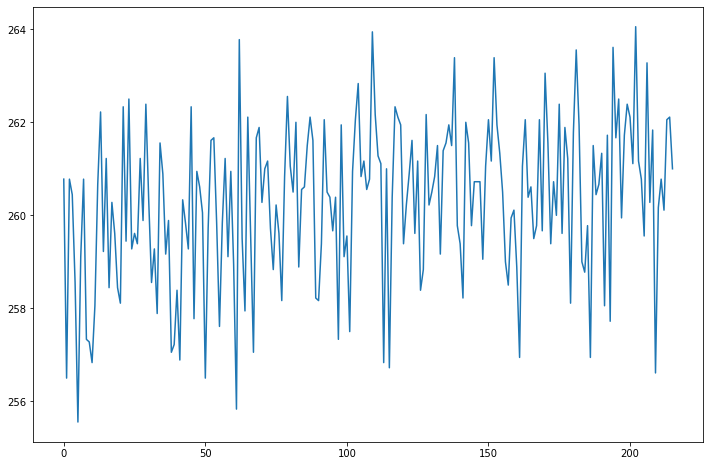

In [482]:
import matplotlib.pyplot as plt

results = grid_search.grid_search_results
plt.figure(figsize=(12, 8))
plt.plot([res['mean_cost'] for res in results])

In [483]:
grid_search.best_optimizer_.schedule(sample).solution_cost

367.0

In [484]:
GreedyOptimization(target_function).schedule(sample).solution_cost

369.0

In [485]:
grid_search.best_optimizer_params_

{'pheromone_decay': 0.1,
 'threshold': 0.42,
 'pheromone_influence': 0.1,
 'heuristic_influence': 0.954992586021436,
 'iters_count': 50,
 'baseline_opt': <__main__.GreedyOptimization at 0x29f1332b8b0>,
 'solution_cost': <function __main__.target_function(tasks, wait_list: set)>}

## Algorithms testing

In [15]:
phe_decay = 0.5
threshold = 0.42
phe_influence = 0.5
heu_influence = 0.8
epochs_count = 500
ants_count = 3
solution_cost = target_function
baseline_opt = GreedyOptimization(solution_cost)

aco_opt = AntColonyOptimization(phe_decay, 
                                threshold, 
                                phe_influence, 
                                heu_influence, 
                                epochs_count, 
                                ants_count,
                                baseline_opt, 
                                solution_cost)

ls_iters_count = 30
sumiaco_opt = SUMIACO(ls_iters_count, **aco_opt.get_params())

min_temp = 1
max_temp = 8
reduction_rule = 'boltzmann'

sao_opt = SimulatedAnnealing(min_temp, 
                             max_temp, 
                             reduction_rule, 
                             baseline_opt, 
                             solution_cost)

In [17]:
data_chars = {'n_nodes': [30, 50, 70, 100, 150],  
              'random_state': [4, 8, 15, 16, 23, 42]}

samples = samples_generation(data_chars, alphas=[1.25, 1.5, 1.75, 2, 2.5])

optimizers = [aco_opt, sao_opt, sumiaco_opt]
labels = ['ACO', 'SAO', 'SUMIACO']
colors = ['green', 'blue', 'red']
opt_costs = [[], [], []]

In [18]:
for label, optimizer, costs in zip(labels, optimizers, opt_costs):
    print("Optimizer:", label)
    for sg_iter, sample_group in enumerate(samples.values()):
        low_value = high_value = values_sum = 0
        for s_iter, sample in enumerate(sample_group):
            solution_cost = optimizer.schedule(sample).solution_cost
            if low_value == 0 or low_value > solution_cost:
                low_value = solution_cost
            if high_value == 0 or high_value < solution_cost:
                high_value = solution_cost
            values_sum += solution_cost
            print("Sample progress:", (s_iter + 1) / len(sample_group))
        print("Sample group progress:", (sg_iter + 1) / len(samples))
        mean_value = values_sum / len(sample_group)
        costs.append([low_value, mean_value, high_value])

Optimizer: ACO
Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.6666666666666666
Sample progress: 0.8333333333333334
Sample progress: 1.0
Sample group progress: 0.04
Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.6666666666666666
Sample progress: 0.8333333333333334
Sample progress: 1.0
Sample group progress: 0.08
Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.6666666666666666
Sample progress: 0.8333333333333334
Sample progress: 1.0
Sample group progress: 0.12
Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.6666666666666666
Sample progress: 0.8333333333333334
Sample progress: 1.0
Sample group progress: 0.16
Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.666666666666

Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.6666666666666666
Sample progress: 0.8333333333333334
Sample progress: 1.0
Sample group progress: 0.56
Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.6666666666666666
Sample progress: 0.8333333333333334
Sample progress: 1.0
Sample group progress: 0.6
Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.6666666666666666
Sample progress: 0.8333333333333334
Sample progress: 1.0
Sample group progress: 0.64
Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.6666666666666666
Sample progress: 0.8333333333333334
Sample progress: 1.0
Sample group progress: 0.68
Sample progress: 0.16666666666666666
Sample progress: 0.3333333333333333
Sample progress: 0.5
Sample progress: 0.6666666666666666
Sample prog

In [65]:
def make_plot(ax, labels, colors, opt_costs):
    x_labels = [str(vol) for vol in samples.keys()]
    for label, color, costs in zip(labels, colors, opt_costs):
        costs = np.array(costs)
        #plt.plot(x_labels, costs[:, 0], color=color, linestyle='--')
        ax.plot(x_labels, costs[:, 1], label=label, color=color)
        #plt.plot(x_labels, costs[:, 2], color=color, linestyle='--')
        ax.fill_between(x_labels, costs[:, 0], costs[:, 2], color=color, alpha=0.3)

    #ax.set_xlabel("Размерность задачи (кол-во вершин, кол-во ребёр)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(x_labels, rotation=45)
    #ax.set_ylabel("Значение целевой функции")
    ax.grid()
    ax.legend()

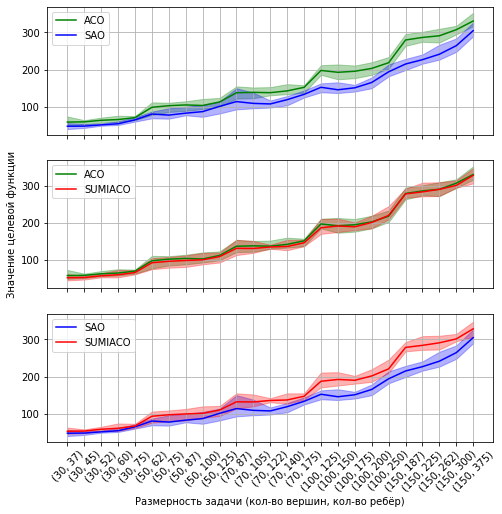

In [66]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True, sharey=True, )
axs = axs.ravel()

for pic_num, data in enumerate([[(labels[i], labels[j]), 
                                 (colors[i], colors[j]), 
                                 (opt_costs[i], opt_costs[j])] 
                                for i, j in [(0, 1), (0, 2), (1, 2)]]):
    lbls, clrs, costs = data
    make_plot(axs[pic_num], lbls, clrs, costs)
axs[-1].set_xlabel("Размерность задачи (кол-во вершин, кол-во ребёр)")
axs[1].set_ylabel("Значение целевой функции")
plt.show()

Из графиков видно, что SAO в подавляющем большинстве случаев находит решение лучше, нежели муравьиный алгоритм (муравьиный алгоритм с локальным поиском). Локальный поиск для муравьиного алгоритма не особо улучшает решение, зато значительно увеличивает время работы.

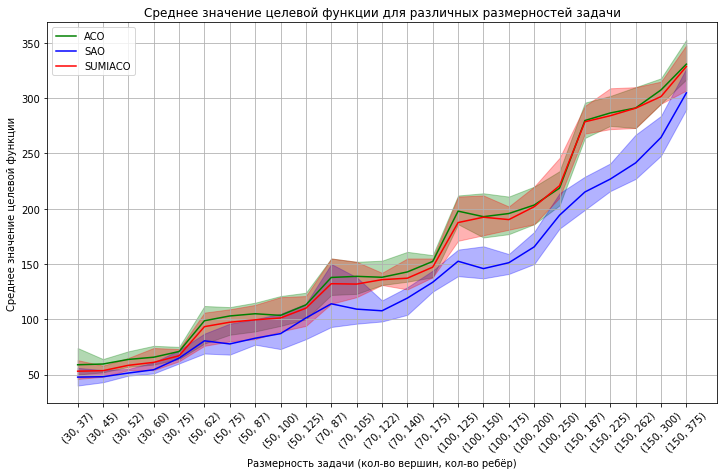

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 7))
plt.title("Среднее значение целевой функции для различных размерностей задачи")

x_labels = [str(vol) for vol in samples.keys()]
for label, color, costs in zip(labels, colors, opt_costs):
    costs = np.array(costs)
    #plt.plot(x_labels, costs[:, 0], color=color, linestyle='--')
    plt.plot(x_labels, costs[:, 1], label=label, color=color)
    #plt.plot(x_labels, costs[:, 2], color=color, linestyle='--')
    plt.fill_between(x_labels, costs[:, 0], costs[:, 2], color=color, alpha=0.3)
    
plt.xlabel("Размерность задачи (кол-во вершин, кол-во ребёр)")
plt.ylabel("Среднее значение целевой функции")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

In [113]:
sao_opt.iters_count

2980

In [120]:
((np.array(opt_costs[0])[:,2] - np.array(opt_costs[0])[:, 0]).std(),
(np.array(opt_costs[1])[:,2] - np.array(opt_costs[1])[:, 0]).std())

(8.943914131967055, 12.55987261081895)

## Greedy vs ACO

In [24]:
phe_decay = 0.8
threshold = 0.0278
phe_influence = 0.599
heu_influence = 0.0278
iters_count = 20
baseline_opt = BaseOptimization(target_function)#GreedyOptimization(target_function)
solution_cost = target_function

aco_opt = AntColonyOptimization(phe_decay, 
                                threshold, 
                                phe_influence, 
                                heu_influence, 
                                iters_count, 
                                baseline_opt, 
                                solution_cost)

In [486]:
aco_opt = grid_search.best_optimizer_
aco_opt.iters_count = 200

In [487]:
# samples generation
samples = list()
n_nodes_lst = [40, 80, 100, 120, 150]
rand_states = [4, 8, 15, 16, 23, 42]
task_volume = []

for n_nodes in n_nodes_lst:
    n_edges_lst = [int(n_nodes * coef) for coef in (1.25, 1.5, 1.75, 2, 2.25)]
    for n_edges in n_edges_lst:
        task_volume.append((n_nodes, n_edges))
        samples.append([])
        for random_state in rand_states:
            sample = data_preprocessing(dag_generator(n_nodes, n_edges, 1, 10, random_state)[1])
            samples[-1].append(sample)

greedy_costs = []
aco_costs = []
for sample_group in samples:
    greedy_cost = aco_cost = 0
    for sample in sample_group:
        greedy_cost += baseline_opt.schedule(sample).solution_cost
        aco_cost += aco_opt.schedule(sample).solution_cost
    greedy_costs.append(greedy_cost / len(sample_group))
    aco_costs.append(aco_cost / len(sample_group))

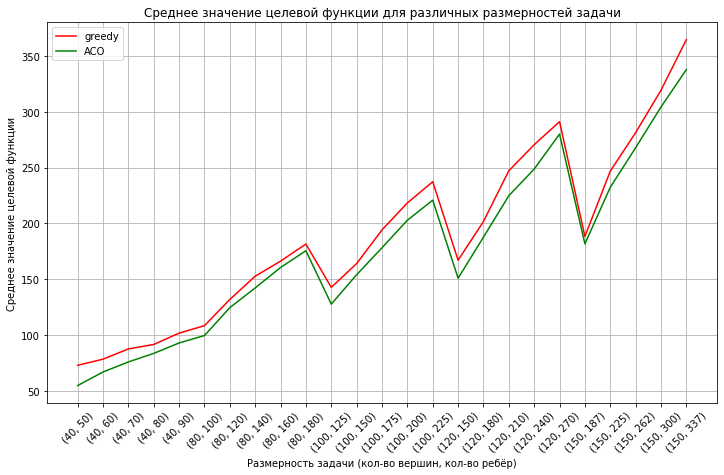

In [488]:
plt.figure(figsize=(12, 7))
plt.title("Среднее значение целевой функции для различных размерностей задачи")
plt.plot([str(vol) for vol in task_volume], greedy_costs, c='red', label='greedy')
plt.plot([str(vol) for vol in task_volume], aco_costs, c='green', label='ACO')
plt.xlabel("Размерность задачи (кол-во вершин, кол-во ребёр)")
plt.ylabel("Среднее значение целевой функции")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

# Drawing

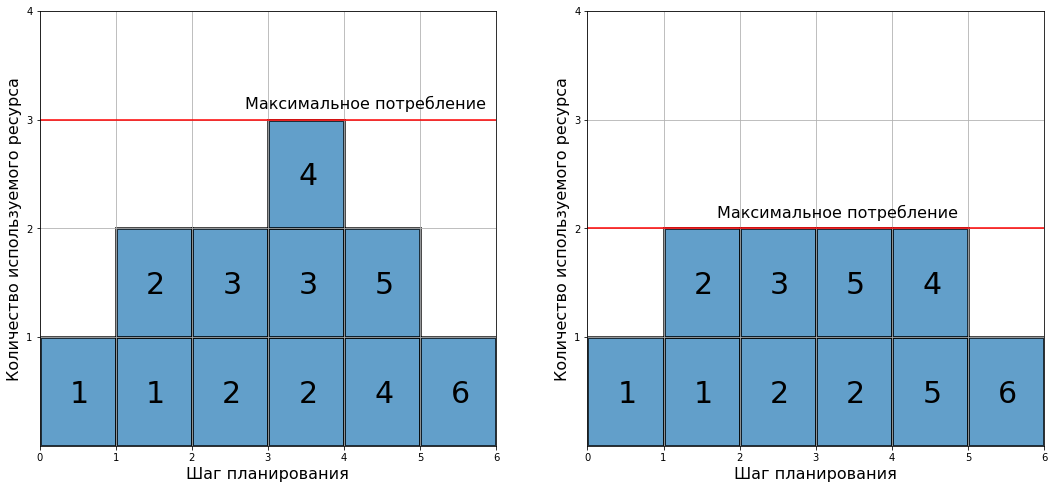

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as pth

fig, axs = plt.subplots(1, 2, figsize=(18, 8))
axs = axs.ravel()

bad_alloc_rects = (
    [(0, 0), 1],
    [(1, 0), 1], 
    [(1, 1), 2],
    [(2, 0), 2],
    [(2, 1), 3],
    [(3, 0), 2],
    [(3, 1), 3],
    [(3, 2), 4],
    [(4, 0), 4],
    [(4, 1), 5],
    [(5, 0), 6]
)
good_alloc_rects = (
    [(0, 0), 1],
    [(1, 0), 1],
    [(1, 1), 2],
    [(2, 0), 2],
    [(2, 1), 3],
    [(3, 0), 2],
    [(3, 1), 5],
    [(4, 0), 5],
    [(4, 1), 4],
    [(5, 0), 6]
)

height = width = 1
bad_line = ((0, 6), (3, 3), 'red')
good_line = ((0, 6), (2, 2), 'red')
for rects, line, ax in zip([bad_alloc_rects, good_alloc_rects], [bad_line, good_line], axs):
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 4)
    ax.set_yticks([1, 2, 3, 4])
    ax.plot(line[0], line[1], color=line[2])
    ax.text(line[1][0] - 0.3, line[1][1] + 0.1, 'Максимальное потребление', fontdict={'fontsize': 16})
    ax.grid()
    for rect, rect_id in rects:
        ax.add_patch(pth.Rectangle(rect, width, height, edgecolor='black', linewidth=3, alpha=0.7))      
        ax.text((2 * rect[0] + 1) / 2 - 0.1, (2 * rect[1] + 1) / 2 - 0.1, str(rect_id), fontdict={'fontsize': 30})
        ax.set_ylabel('Количество используемого ресурса', fontdict={'fontsize': 16})
        ax.set_xlabel('Шаг планирования', fontdict={'fontsize': 16})

plt.savefig('Resource_dist')